**In this project, you need to program a bot that automatically trades stocks for you. The bot
should use sophisticated machine learning algorithms to predict future stock prices and then
decide to buy or sell the stock. You should test the performance of the bot empirically over a
certain time frame and for different stocks.**


#### Data
You can collect your own stock price data for which you want to train the algorithms.
The example data set are daily stock prices of Apple from January to the end of March 2021.
You can use the same set and/or another of your choosing.

#### Tasks
• Choose a stock/index/currency/commodity/etc. and collect price data for a certain time
frame that you want to use to train and test the algorithms. To train these algorithms
you should have a sufficient amount of data points. Daily returns are easily accessible
but you can also try to look at intra-day data and go the high-frequency trading route.

• As a benchmark, come up with some easy rules to buy and sell the stock (i.e. buy the
stock if it was down the day before, ...). Also implement an algorithm that buys the stock
at random. Test the performance of the strategies empirically.

• Now use more sophisticated approaches to predict the future stock price and let the
trading bot invest based on these forecasts. This is a typical time series application. Check
if the assumptions of the models hold. Find the best time series model and implement it
into the trading bot. Show the performance.

• Try to use other machine learning algorithms to predict stock prices and compare their
performance.

• Your trading bot should work well for your stock and time frame now. What about
another time frame? Or another stock/index?

• It probably won’t perform as well as it did before and you would need to adjust the
algorithm’s parameters or change it altogether. It requires a lot of time to do that
manually every time. Write a program that automatically finds the best approach for
any given asset and time frame to optimize your trading bot.

#### Possible Extensions:
• Assume that your trading bot can also sell short instead of just buying assets.
• In a real setting, you would also need to consider trading fees and probably also taxes.
What would change? How can you take this into account when optimizing your bot?

# 1. Import Libraries and Data Preprocessing

In [126]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
%matplotlib inline
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import random

# Import libraries for Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Import libraries for XGBoost
from xgboost import XGBRegressor
import xgboost as xgb

# preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

For measuring the performance of models we had created metrics like - 
* MAPE - Mean absolute percentage error
* WMAPE - Weighted mean absolute percentage error

In [2]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = actual[j] - predicted[j]
        else:
            rej[j] = predicted[j]
            
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100

def weighted_mean_absolute_percentage_error(y_true, y_pred):
    if sum(y_true) == 0:
        denominator = 1
    else:
        denominator = sum(y_true)
    return (sum(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))))*100/denominator
    

## 1.1 Import data for stocks

In [5]:
# here we are using apples stock data
apple = pd.read_csv("AAPL_22-23.csv")
amazon = pd.read_csv("AMZN_22-23.csv")
google = pd.read_csv("GOOG_22-23.csv")

## consider only last 6 months data August 2022 - January 2023
apple['Date'] = pd.to_datetime(apple['Date'])
amazon['Date'] = pd.to_datetime(amazon['Date'])
google['Date'] = pd.to_datetime(google['Date'])

apple = apple[(apple['Date']>='2022-08-01') & (apple['Date'] <='2023-01-31')]
amazon = amazon[(amazon['Date']>='2022-08-01') & (amazon['Date'] <='2023-01-31')]
google = google[(google['Date']>='2022-08-01') & (google['Date'] <='2023-01-31')]

## To calculate the return, we already have returns in the dataset
apple['returns'] = ( apple['Adj Close'] - apple['Adj Close'].shift(1) )/(apple['Adj Close'].shift(1))
amazon['returns'] = ( amazon['Adj Close'] - amazon['Adj Close'].shift(1) )/(amazon['Adj Close'].shift(1))
google['returns'] = ( google['Adj Close'] - google['Adj Close'].shift(1) )/(google['Adj Close'].shift(1))

apple = apple.dropna()
amazon = amazon.dropna()
google = google.dropna()
# Convert date to DateTime format

apple.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,returns
117,2022-08-02,160.100006,162.410004,159.630005,160.009995,159.280212,59907000,-0.009287
118,2022-08-03,160.839996,166.589996,160.750000,166.130005,165.372314,82507500,0.038248


## 1.2 Visualization of Adj Close and Returns values - Trend and Seasonality

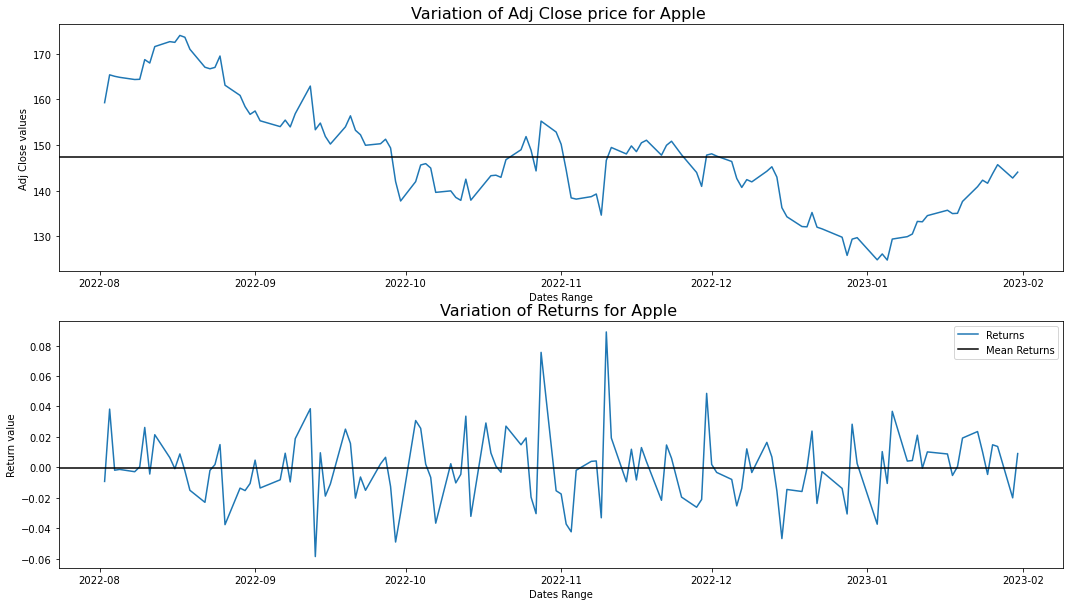

In [6]:
fig, axes = plt.subplots(2,1, figsize = (18,10))
sns.lineplot(x='Date', y='Adj Close', data=apple, ax=axes[0])
axes[0].axhline(apple['Adj Close'].mean(), color='k')
axes[0].set_xlabel('Dates Range')
axes[0].set_ylabel('Adj Close values')
axes[0].set_title("Variation of Adj Close price for Apple ", fontsize = 16)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

sns.lineplot(x='Date', y='returns', data=apple, ax=axes[1])
axes[1].axhline(apple['returns'].mean(), color='k')
axes[1].set_xlabel('Dates Range')
axes[1].set_ylabel('Return value')
axes[1].set_title("Variation of Returns for Apple ", fontsize = 16)
plt.legend(('Returns','Mean Returns'));

* In comparision to Adj Close price, return is quite flactuating and 
* Trends and seasonality is not visible from the graph for returns

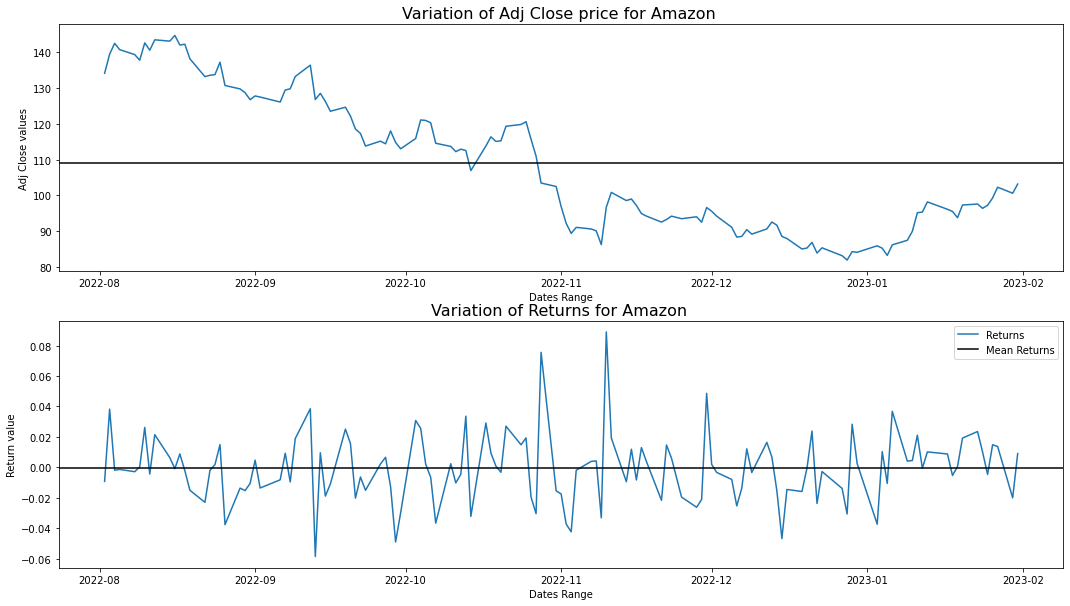

In [7]:
fig, axes = plt.subplots(2,1, figsize = (18,10))
sns.lineplot(x='Date', y='Adj Close', data=amazon, ax=axes[0])
axes[0].axhline(amazon['Adj Close'].mean(), color='k')
axes[0].set_xlabel('Dates Range')
axes[0].set_ylabel('Adj Close values')
axes[0].set_title("Variation of Adj Close price for Amazon ", fontsize = 16)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

sns.lineplot(x='Date', y='returns', data=apple, ax=axes[1])
axes[1].axhline(apple['returns'].mean(), color='k')
axes[1].set_xlabel('Dates Range')
axes[1].set_ylabel('Return value')
axes[1].set_title("Variation of Returns for Amazon ", fontsize = 16)
plt.legend(('Returns','Mean Returns'));

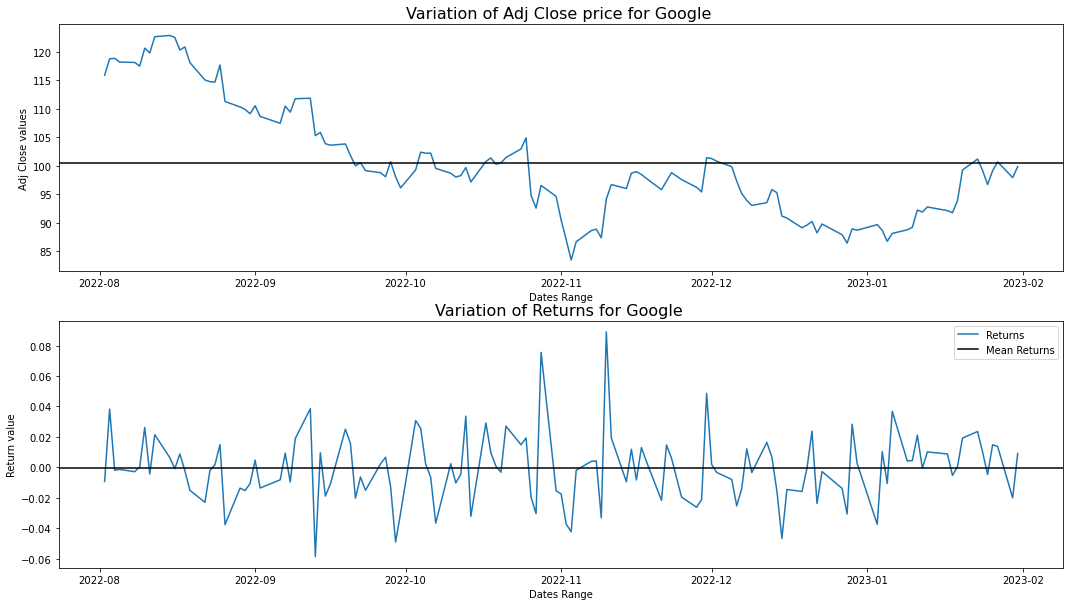

In [8]:
fig, axes = plt.subplots(2,1, figsize = (18,10))
sns.lineplot(x='Date', y='Adj Close', data=google, ax=axes[0])
axes[0].axhline(google['Adj Close'].mean(), color='k')
axes[0].set_xlabel('Dates Range')
axes[0].set_ylabel('Adj Close values')
axes[0].set_title("Variation of Adj Close price for Google ", fontsize = 16)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

sns.lineplot(x='Date', y='returns', data=apple, ax=axes[1])
axes[1].axhline(apple['returns'].mean(), color='k')
axes[1].set_xlabel('Dates Range')
axes[1].set_ylabel('Return value')
axes[1].set_title("Variation of Returns for Google ", fontsize = 16)
plt.legend(('Returns','Mean Returns'));

# 2 ARIMA model

Three factors define ARIMA model, it is defined as ARIMA(p,d,q) where p, d, and q denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively.

In our model selection process we find ARIMA performed better than, SARIMA, Prophet and XGBoost in terms of net profit. We will use ARIMA model to evaluate its performace on apple, amazon and google stocks.

In [73]:
def plot_actual_forecast_returns(actual, forecast, forecast_variable):
    
    fig, ax = plt.subplots(1,1, figsize = (16,8))

    plt.plot(actual['returns'])
    plt.plot(forecast[forecast_variable])
    ax.axhline(actual['returns'].mean(), linestyle = '--', color = 'k')

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Returns', fontsize=20)
    plt.ylabel('Stock returns', fontsize=16);

    print("Mean Absolute Percent Error(MAPE) {}".format(mean_absolute_percentage_error(
    forecast['returns'], forecast[forecast_variable])))

    print("Root Mean Squared Error(RMSE) {}".format(np.sqrt(mean_squared_error(
    forecast['returns'], forecast[forecast_variable]))))

    print("Weighted Mean Absolute Percentage Error (WMAPE) {}".format(weighted_mean_absolute_percentage_error(
    forecast['returns'], forecast[forecast_variable])))




In [89]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
 # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
 # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
 # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    #print(rmse)
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #print(order)
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
    #print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    return best_cfg

def parameter_tuning_arima(data):
    # evaluate parameters
    p_values = [1,2,3]
    d_values = [0,1]
    q_values = [1,2,3]
    warnings.filterwarnings("ignore")
    best_param = evaluate_models(data['returns'], p_values, d_values, q_values)
    return best_param

## 2.1 Rolling forecast using ARIMA Model

In [160]:
def stock_forecast(data):
    
    ## Set date as index and seperate the data for train and test
    data_arima = data.set_index('Date')

    # for the given period we selected training data till 15th of match and rest is test data on which we would evaluate 
    # the model performance 
    train_end = datetime(2023, 1, 15)
    test_end = datetime(2023, 2, 1)

    train_data = data_arima[:train_end]
    test_data = data_arima[train_end+timedelta(days = 1):]
    
    # get best parameter for the model based on company stock using hyperparameter tuning
    best_param = parameter_tuning_arima(train_data)
    #print(best_param)

    # rolling forecast taking into account actual data to predict next days

    rolling_pred_arima = test_data.copy()

    for train_end in test_data.index:
        rolling_train_data = data_arima[:train_end - timedelta(days=1)]
        model=ARIMA(rolling_train_data['returns'],order=best_param)
        model_fit = model.fit()
    
        pred = model_fit.forecast()
        rolling_pred_arima.loc[train_end,'rolling_forecast_arima'] = pred.item()
    
    plot_actual_forecast_returns(data_arima, rolling_pred_arima, 'rolling_forecast_arima')    
    return rolling_pred_arima

ARIMA model with parameter tuning able to capture the changes in patterns,
 - we have used training period from august 1st 2022 till 15th Jan 2023, and test period from 16th Jan till 31st Jan 2023.
 - For google and amazon we have lowest MAPE score and for apple we have losest RMSE score.
 - Performace of ARIMA for all these 3 companies seems to be average
 - We required more complex model with hyperparameter tuning and extra features to capture the returns pattern more accurately.


Mean Absolute Percent Error(MAPE) 220.538569039754
Root Mean Squared Error(RMSE) 0.015368190438039223
Weighted Mean Absolute Percentage Error (WMAPE) 208.06172103012648


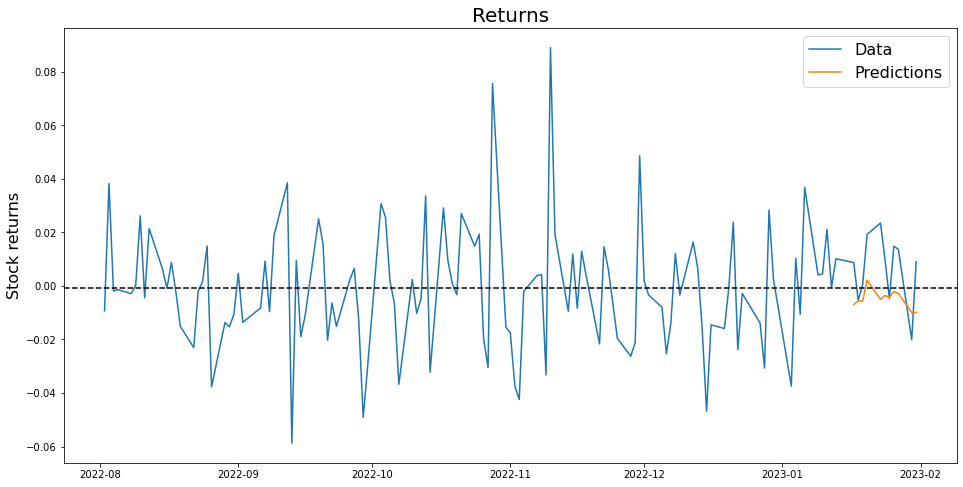

In [161]:
forecast_apple = stock_forecast(apple)

Mean Absolute Percent Error(MAPE) 89.49673898641781
Root Mean Squared Error(RMSE) 0.022056189513279065
Weighted Mean Absolute Percentage Error (WMAPE) 384.9805726258235


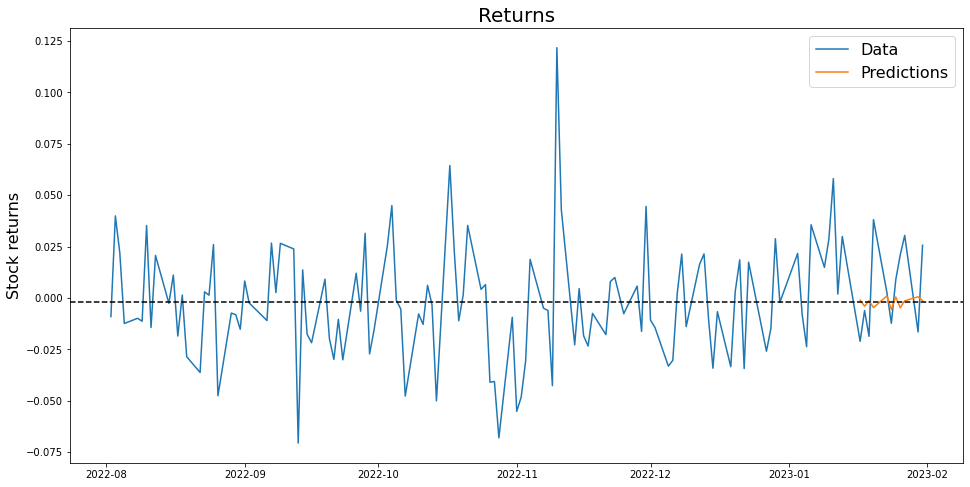

In [162]:
forecast_amazon = stock_forecast(amazon)

Mean Absolute Percent Error(MAPE) 89.58013540110682
Root Mean Squared Error(RMSE) 0.02570734887834724
Weighted Mean Absolute Percentage Error (WMAPE) 304.2155118366326


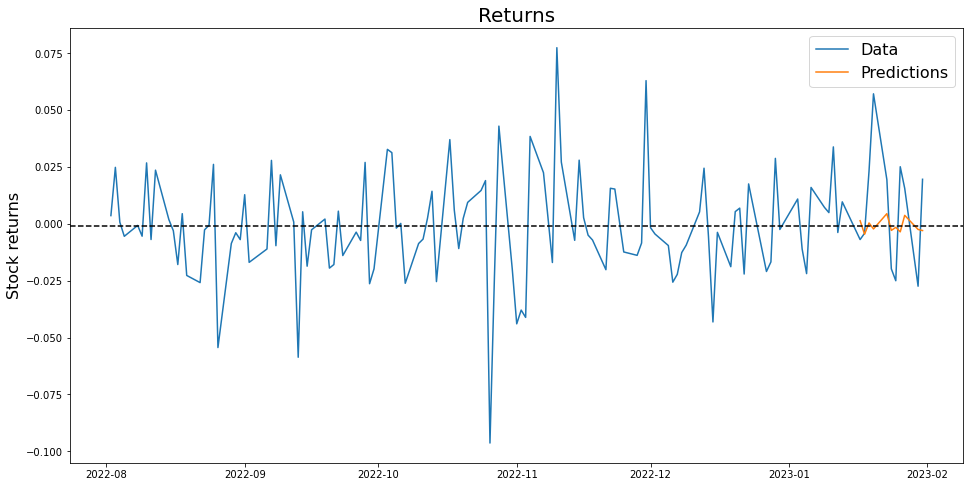

In [163]:
forecast_google = stock_forecast(google)

# 3 Trading Bot

## 3.1 Rule - 2: Buy-Sell-Hold

We will start with buying stock, then based on returns of next day
 - either sell or hold
 - if sell then buy or hold
 - repeat and in the end sell (if last action was buy)


In [164]:
def trading_bot_rule2(data,start_Adj_close,actual_or_forecast, invest=100):
    stock = 0
    money_left = invest
    today_price = start_Adj_close
    
    # variable to store our last bought action, at start we will buy a stock
    want_to_buy = True
    # variable to store our last sell action, end action should be sell
    want_to_sell = False
    # variable to indicate if we are holding or not?
    hold = False
    
    # store actions taken throughout the trading period
    actions = ["" for j in range(len(data))]
    
    for i in range(len(data)):
        
        # at first we will buy some stocks
        if i == 0:
            actions[0] = 'buy'
            actions[len(data)-1] = 'hold'
            stock = money_left/today_price
            money_left = 0
            want_to_buy = False
            want_to_sell = True
            
        else: # normal situations
            # if wants to sell
            if want_to_sell:
                if data.loc[i, actual_or_forecast] < 0:
                    actions[i] = 'sell' 
                    money_left = stock*today_price
                    stock = 0
                    want_to_buy = True
                    want_to_sell = False
                elif data.loc[i, actual_or_forecast] >= 0: # the price is still increasing, so better to wait 
                     actions[i] = 'hold'                  # more until the higher possible price to sell with
                        
            # if want to buy
            elif want_to_buy:
                if (data.loc[i, actual_or_forecast] > 0) & (i !=len(data)-1) :
                    actions[i] = 'buy'
                    stock = money_left/today_price
                    money_left = 0
                    want_to_buy = False
                    want_to_sell = True
                elif data.loc[i,actual_or_forecast] <=0:
                    actions[i] = 'hold'
                    
        # on the last day sell if last trading was bought            
        if (i == len(data)-1) & (want_to_buy==False):
            actions[i] = 'sell'
            money_left = stock*today_price
            stock = 0
            
                    
        # update today's price
        today_price = data.iloc[i]['Adj Close']
                    
    data['actions'] = actions
    return data, (money_left-invest)     

# 4 Models evaluation - on profit

### 4.1 Trading Bot - Rule2 (Buy-Sell-Hold) performance 

In [165]:
# get the start Adj Close value for every company before trading period
start_Adj_close_apple = np.array(apple[apple['Date'] == '2023-01-13']['Adj Close'])[0]
start_Adj_close_amazon = np.array(amazon[amazon['Date'] == '2023-01-13']['Adj Close'])[0]
start_Adj_close_google = np.array(google[google['Date'] == '2023-01-13']['Adj Close'])[0]

# Reset the index of forecast dataset
forecast_apple_bot = forecast_apple.reset_index()
forecast_amazon_bot = forecast_amazon.reset_index()
forecast_google_bot = forecast_google.reset_index()

# setting up Investment
invest = 100

###### returns for Apple ######
forecast_apple_bot, profit_apple = trading_bot_rule2(forecast_apple_bot,start_Adj_close_apple,'rolling_forecast_arima', invest)
optimum_apple_bot, opptimum_profit_apple = trading_bot_rule2(forecast_apple_bot,start_Adj_close_apple,'returns', invest)

###### returns for Amazon ######
forecast_amazon_bot, profit_amazon = trading_bot_rule2(forecast_amazon_bot,start_Adj_close_amazon,'rolling_forecast_arima', invest)
optimum_amazon_bot, opptimum_profit_amazon = trading_bot_rule2(forecast_amazon_bot,start_Adj_close_amazon,'returns', invest)

###### returns for Google ######
forecast_google_bot, profit_google = trading_bot_rule2(forecast_google_bot,start_Adj_close_google,'rolling_forecast_arima', invest)
optimum_google_bot, opptimum_profit_google = trading_bot_rule2(forecast_google_bot,start_Adj_close_google,'returns', invest)


print(f'Returns from trading period for apple stcoks: {np.round(profit_apple,2)}')
print(f'Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: {np.round(opptimum_profit_apple,2)}')

print('-------------------------------------------------')

print(f'Returns from trading period for amazon stcoks: {np.round(profit_amazon,2)}')
print(f'Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: {np.round(opptimum_profit_amazon,2)}')

print('-------------------------------------------------')

print(f'Returns from trading period for google stcoks: {np.round(profit_google,2)}')
print(f'Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: {np.round(opptimum_profit_google,2)}')


Returns from trading period for apple stcoks: 2.81
Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: 9.39
-------------------------------------------------
Returns from trading period for amazon stcoks: -2.6
Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: 8.17
-------------------------------------------------
Returns from trading period for google stcoks: 5.21
Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold) for apple: 14.02


# 5 Conclusion

For all the stocks we are getting profit which is close to optimum
 - For the same trading period and investment google provides more profit compared to apple and amazon
 - More complex rule using short selling could improve the net return, this need to be explored
 - ARIMA model performs well for returns forecasting for various companies.
 - Its seems to be robust even for different period of time
 - Future steps would invove using Neural Network (NN) like Long Short Term Memory (LSTM) and having more sopisticated trading algorithum which not only consider historical data but also external input like correlation with other stocks price, technological changes, pandemic etc.